In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('studyramaEnglish.csv')
with open('L+MFinal.json', 'r', encoding='utf-8') as f:
    programs_data = json.load(f)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    """Generate BERT embedding for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# we extract skills from the 'Skills' column in the jobs dataset
occupation_skills = set()
for skills in df['Skills'].dropna():
    if isinstance(skills, str):  
        occupation_skills.update(skills.split(', '))  
    elif isinstance(skills, list):  
        occupation_skills.update(skills) 

# and extract skills from the 'Skills' field in each program
program_skills = set()
for program in programs_data:
    if 'Skills' in program: 
        skills = program['Skills']
        if isinstance(skills, str):  
            program_skills.update(skills.split(', '))  
        elif isinstance(skills, list):  
            program_skills.update(skills)

# function to find  similar skills using the (achassements) embeddings
def get_similar_skills(occupation_skills, program_skills, threshold=0.7):
    common_skills = set()
    
    occupation_embeddings = {skill: get_bert_embedding(skill) for skill in occupation_skills}
    
    for prog_skill in program_skills:
        prog_embedding = get_bert_embedding(prog_skill)
        
        for occ_skill, occ_embedding in occupation_embeddings.items():
            similarity = cosine_similarity([prog_embedding], [occ_embedding])[0][0]
            
            if similarity > threshold:  
                common_skills.add(occ_skill)
                common_skills.add(prog_skill)
    
    return common_skills

# Calculate common skills
common_skills = get_similar_skills(occupation_skills, program_skills)
count_common_skills = len(common_skills)


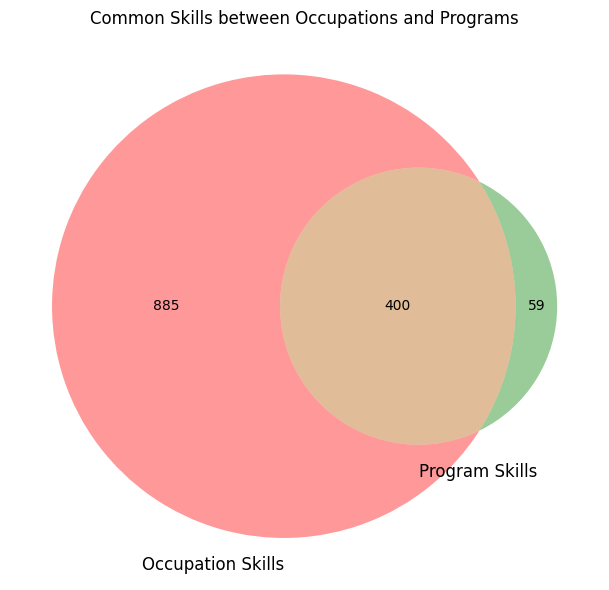

Number of unique occupation skills: 885
Number of unique program skills: 59
Number of common skills: 400


In [2]:

# Create the Venn diagram
fig, ax = plt.subplots(figsize=(8, 6))
venn = venn2(subsets=(len(occupation_skills), len(program_skills), count_common_skills),
             set_labels=('Occupation Skills', 'Program Skills'), ax=ax)

# Set the label for the intersection with the count of common skills
venn.get_label_by_id('11').set_text(str(count_common_skills))

# Set the title
plt.title(f"Common Skills between Occupations and Programs")

# Show the plot
plt.tight_layout()
plt.show()

# Print the counts for verification
print(f"Number of unique occupation skills: {len(occupation_skills)}")
print(f"Number of unique program skills: {len(program_skills)}")
print(f"Number of common skills: {count_common_skills}")


In [10]:
from scipy.stats import chi2_contingency
import pandas as pd

# Create a list of all unique skills across both datasets
all_skills = list(occupation_skills.union(program_skills))

# Create a contingency table with integers (0 or 1)
contingency_table = pd.DataFrame(0, columns=["Occupation Skills", "Program Skills"], index=all_skills)

# Populate the contingency table
for skill in all_skills:
    cont_occupation = 1 if skill in occupation_skills else 0
    cont_program = 1 if skill in program_skills else 0
    contingency_table.loc[skill] = [cont_occupation, cont_program]

# Apply Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table.values)

# Output the results
print("Chi-Square Test Results")
print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Values:")
print(expected)


Chi-Square Test Results
Chi-Square Value: 944.0
P-Value: 0.48469677805493344
Degrees of Freedom: 943
Expected Values:
[[0.9375 0.0625]
 [0.9375 0.0625]
 [0.9375 0.0625]
 ...
 [0.9375 0.0625]
 [0.9375 0.0625]
 [0.9375 0.0625]]


In [49]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Ensure the model is in evaluation mode
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [50]:
def get_bert_embeddings(texts):
    # Tokenize the input text
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Get the hidden states (embeddings)
    with torch.no_grad():  # Don't need gradients for inference
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling for sentence embedding
    
    return embeddings

# Example: Generate embeddings for a list of skills
skills = df['Skills'].dropna().tolist()  # Assuming 'Skills' is a column in your DataFrame
skill_embeddings = get_bert_embeddings(skills)


In [51]:
from sklearn.cluster import KMeans

# Convert the embeddings to a numpy array
skill_embeddings = skill_embeddings.numpy()

# Use KMeans clustering
kmeans = KMeans(n_clusters=5)  # Choose the number of clusters
clusters = kmeans.fit_predict(skill_embeddings)

# Assign the cluster labels to your dataframe
df['Cluster'] = clusters


In [52]:
print(df[['Skills', 'Cluster']].head())


                                              Skills  Cluster
0  ['Negotiation skills', 'Analytical and synthes...        3
1  ['Multidisciplinary expertise and sense of ris...        4
2  ['Interest in finance and understanding of fin...        4
3  ['English proficiency', 'Interest and understa...        4
4  ['Solid knowledge in legal, technical and mana...        0
